# Tutorial

In this little tutorial, we will show you how to use Moniker to sample from categorical distributions in constant time. We will also compare this to the famous `numpy.random.choice` function for sampling categorical distributions to get a sense of how much faster Alias sampling is!

First, let's import our packages.

In [1]:
import sys
sys.path.append("../src/")

import numpy as np 
import matplotlib.pyplot as plt
import time

from moniker import Sampler

Let's use an array of four weights (unnormalized probabilities) to show that Moniker's samples and the samples from `numpy.random.choice` match the actual distribution.

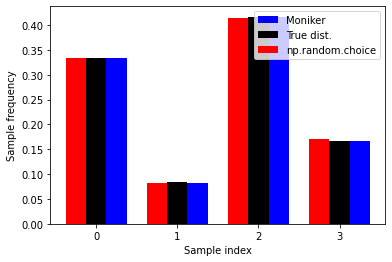

In [2]:
weights = np.array([4, 1, 5, 2])
sampler = Sampler(weights)

num_samples = 100000
samples = sampler.sample(num_samples = num_samples)

np_samples = np.zeros(num_samples)
for s in range(num_samples):
    np_samples[s] = np.random.choice(
        range(weights.shape[0]), 
        p=weights/np.sum(weights)
    )

my_uniques, my_counts = np.unique(samples, return_counts=True)
np_uniques, np_counts = np.unique(np_samples, return_counts=True)
    
plt.figure()
plt.bar(my_uniques+0.25, my_counts/num_samples, color='blue',
            label="Moniker", align='center', width=0.25)
plt.bar(range(weights.shape[0]), weights/np.sum(weights), color='black',
            label="True dist.", align='center', width=0.25)
plt.bar(np_uniques-0.25, np_counts/num_samples, color='red',
            label="np.random.choice", align='center', width=0.25)

plt.xlabel('Sample index')
plt.ylabel('Sample frequency')
plt.xticks(range(4))
plt.legend()
plt.show()

So, we know Moniker works! The distribution of its generated samples match with the true distribution and `numpy.random.choice`.

Now, let's see how much faster Moniker is compared to `numpy.random.choice`. We will sample from randomly initialized distributions (`weights = np.random.uniform(size=num_weights`) of varying length (`num_weights`), and plot the time it takes to generate a varying number of samples (`num_samples`) using `numpy.random.choice` and Moniker.

In [3]:
def colors_from_array(arr, c): # nice for plotting
    cmap = plt.get_cmap(c)
    colors = [cmap(i) for i in np.linspace(0.3,1,len(arr))]
    return colors, cmap

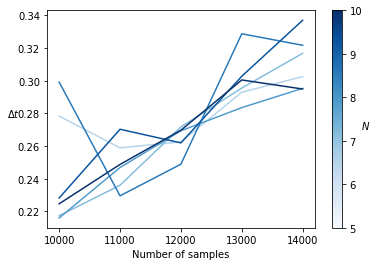

In [4]:
num_samples_range = np.arange(10000,15000,1000)
num_weights_range = np.arange(5,11)
colors, my_cmap = colors_from_array(num_weights_range, "Blues")

plt.figure()
for w,num_weights in enumerate(num_weights_range):
    weights = np.random.uniform(size=num_weights)
    
    Δt = np.zeros_like(num_samples_range, dtype=np.float64)
    sampler = Sampler(weights)
    for n,num_samples in enumerate(num_samples_range):
        ti_moniker = time.time()
        samples = sampler.sample(num_samples=num_samples)
        t_moniker = time.time() - ti_moniker

        np_samples = np.zeros(num_samples)
        ti_numpy = time.time()
        for i in range(num_samples):
            np_samples[i] = np.random.choice(
                num_weights, 
                p=weights/sum(weights)
            )
        t_numpy = time.time() - ti_numpy

        Δt[n] = t_numpy - t_moniker

    plt.plot(
        num_samples_range, Δt, 
        color=colors[w], 
        label=r'$N = {}$'.format(num_weights)
    )
    
sm = plt.cm.ScalarMappable(
    cmap=my_cmap, 
    norm=plt.Normalize(
        vmin=min(num_weights_range), 
        vmax=max(num_weights_range)
    )
)
cbar = plt.colorbar(sm)
cbar.set_label(r'$N$', rotation=0)

plt.xlabel('Number of samples')
plt.ylabel(r'$\Delta t$', rotation=0)

plt.show()

This is quite a nice speedup!